In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [2]:
from google.colab import files
uploaded = files.upload()


In [3]:
import zipfile
import os

# Define the name of the uploaded zip file
zip_filename = 'Data.zip'  # Replace with the actual name of your zip file

# Define the directory where you want to extract the files
extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List extracted files to confirm
print(os.listdir(extract_dir))


['__MACOSX', 'Data']


In [4]:
# Define paths to the train, validation, and test directories
train_dir = '/content/dataset/Data/train'
val_dir = '/content/dataset/Data/val'
test_dir = '/content/dataset/Data/test'

In [5]:
# Converting to tensor and Normalize with ImageNet stats
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


torch.Size([3, 224, 224])


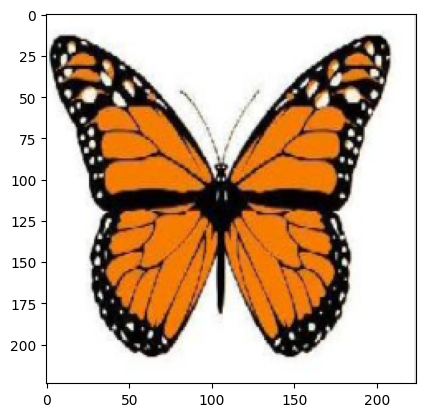

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Load a sample image
sample_image_path = '/content/dataset/Data/train/butterfly/image_0001.jpg'
image = Image.open(sample_image_path)

# Apply the transformations
transformed_image = transform(image)

# Check the shape of the transformed image
print(transformed_image.shape)  # Should be [3, 224, 224]

# Display the transformed image
plt.imshow(transformed_image.permute(1, 2, 0))  # Convert tensor to HWC for display
plt.show()


In [7]:
# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the first batch of the train loader
images, labels = next(iter(train_loader))
print(images.shape)  # Should be (32, 3, 224, 224) if batch_size=32 and image_size=(224, 224)
print(labels)

torch.Size([16, 3, 224, 224])
tensor([0, 3, 1, 2, 3, 0, 3, 0, 0, 3, 3, 4, 1, 2, 1, 3])


In [8]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
# Load VGG19 pre-trained on ImageNet
model = models.vgg19(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [80]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [81]:
# Modify the classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features=num_features, out_features=5).to(device)

In [82]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [83]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [84]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [85]:
# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4, weight_decay = 0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [86]:
# Training function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, pred = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (pred == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation loop
        val_acc, val_loss, _ = evaluate_model(model, val_loader, criterion)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, \n'
              f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {(100*val_acc):.2f}%')

        scheduler.step(avg_val_loss)


In [87]:
# Evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    e_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss = criterion(outputs, labels)
            e_loss += loss.item() * inputs.size(0)

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, e_loss, cm

In [88]:
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

Epoch 1/10, Loss: 0.7489, Train Accuracy: 73.60%, 
Validation Loss: 0.1628, Validation Accuracy: 94.00%
Epoch 2/10, Loss: 0.0480, Train Accuracy: 98.80%, 
Validation Loss: 0.0329, Validation Accuracy: 98.00%
Epoch 3/10, Loss: 0.0093, Train Accuracy: 100.00%, 
Validation Loss: 0.0708, Validation Accuracy: 96.00%
Epoch 4/10, Loss: 0.0035, Train Accuracy: 100.00%, 
Validation Loss: 0.0505, Validation Accuracy: 96.00%
Epoch 5/10, Loss: 0.0017, Train Accuracy: 100.00%, 
Validation Loss: 0.0276, Validation Accuracy: 100.00%
Epoch 6/10, Loss: 0.0018, Train Accuracy: 100.00%, 
Validation Loss: 0.0436, Validation Accuracy: 98.00%
Epoch 7/10, Loss: 0.0023, Train Accuracy: 100.00%, 
Validation Loss: 0.0461, Validation Accuracy: 98.00%
Epoch 8/10, Loss: 0.0033, Train Accuracy: 100.00%, 
Validation Loss: 0.0493, Validation Accuracy: 98.00%
Epoch 9/10, Loss: 0.0037, Train Accuracy: 100.00%, 
Validation Loss: 0.0475, Validation Accuracy: 98.00%
Epoch 10/10, Loss: 0.0031, Train Accuracy: 100.00%, 
Val

In [89]:
def plot_confusion_matrix(cm, classes):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

Training Accuracy: 1.0000
Training Confusion Matrix:



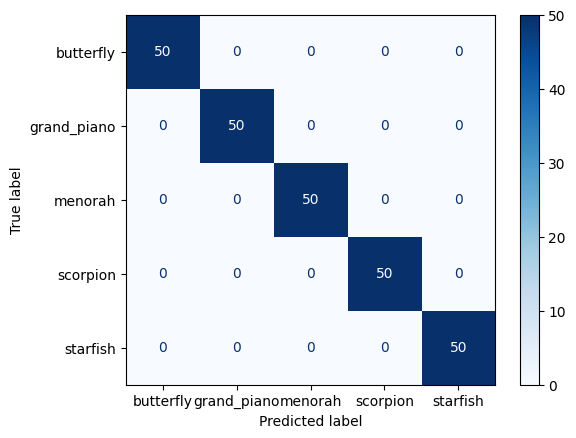

Validation Accuracy: 0.9800
Validation Confusion Matrix:



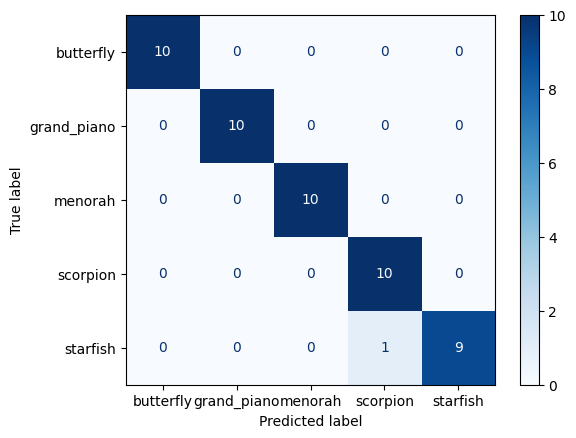

Test Accuracy: 1.0000
Test Confusion Matrix:



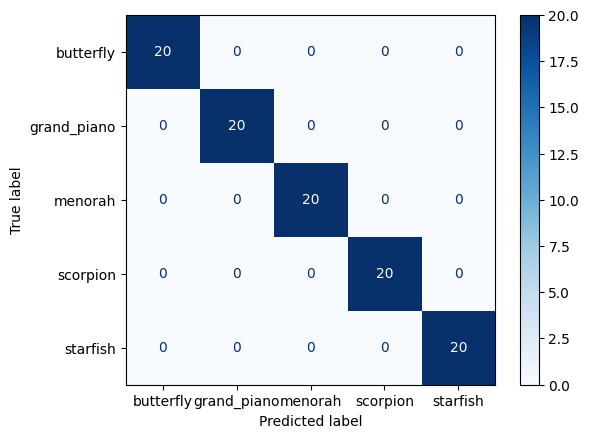

In [90]:
# Evaluate on the training set
train_accuracy, _, train_cm = evaluate_model(model, train_loader, criterion)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Confusion Matrix:\n')
plot_confusion_matrix(train_cm, classes=train_dataset.classes)


# Evaluate on the validation set
val_accuracy, _, val_cm = evaluate_model(model, val_loader, criterion)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Confusion Matrix:\n')
plot_confusion_matrix(val_cm, classes=train_dataset.classes)


# Evaluate on the test set
test_accuracy, _, test_cm = evaluate_model(model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Confusion Matrix:\n')
plot_confusion_matrix(test_cm, classes=train_dataset.classes)



In [33]:
# Print names and modules
for name, module in model.features.named_children():
    print(f"Name: {name}, Module: {module}")

Name: 0, Module: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 1, Module: ReLU(inplace=True)
Name: 2, Module: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 3, Module: ReLU(inplace=True)
Name: 4, Module: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Name: 5, Module: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 6, Module: ReLU(inplace=True)
Name: 7, Module: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 8, Module: ReLU(inplace=True)
Name: 9, Module: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Name: 10, Module: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 11, Module: ReLU(inplace=True)
Name: 12, Module: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 13, Module: ReLU(inplace=True)
Name: 14, Module: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Name: 

In [34]:
def output_per_layer(model, x):
    model.eval()
    model.to(device)
    x = x.to(device)
    outputs = {}
    layer_info = {}
    for name, layer in model.features.named_children():
        if 'identity' in name:
            break

        # Else forward
        x = layer(x)
        x.shape
        outputs[name] = x.detach().cpu().numpy()

        if hasattr(layer, 'kernel_size'):
            layer_info[name] = {'kernel_size': np.array(layer.kernel_size), 'stride': layer.stride}

    return outputs, layer_info

Feature Maps for each image with Max Activation



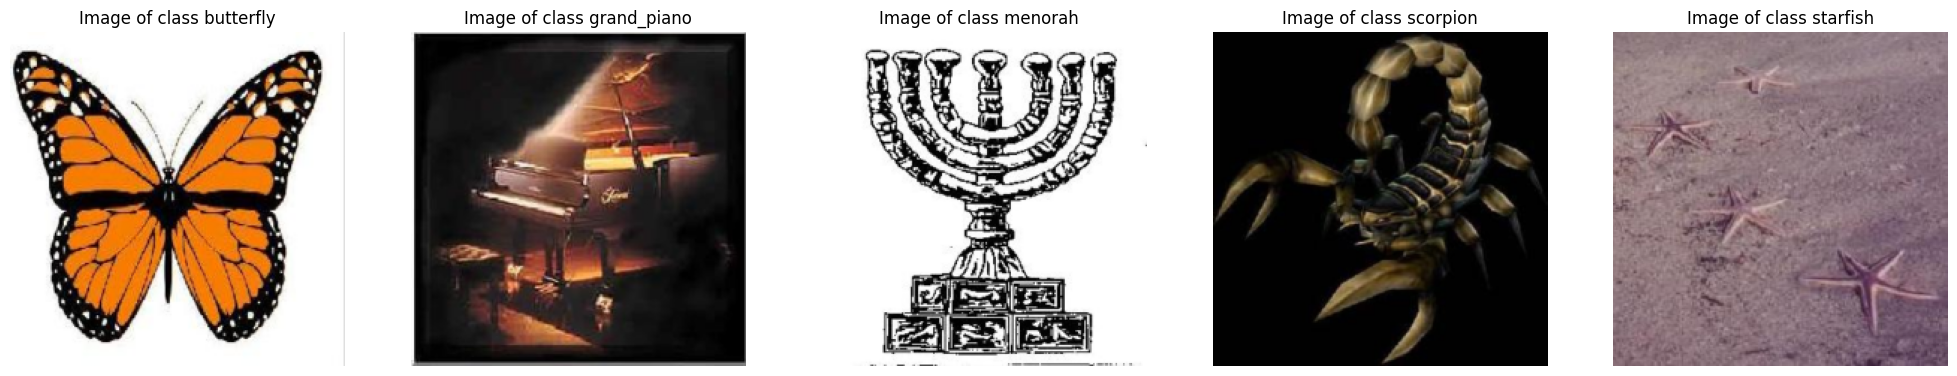

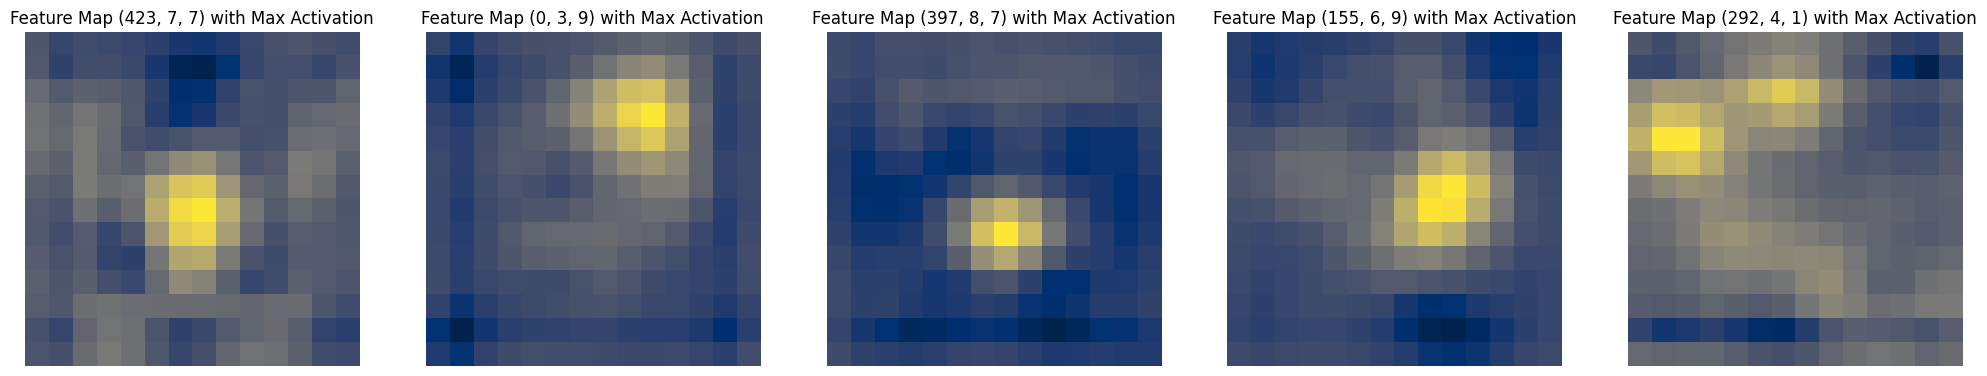

In [35]:
def find_maximally_activated_neuron(model, image_tensor):
    model = model.to(device)
    image_tensor = image_tensor.to(device)
    outputs, layer_info = output_per_layer(model, image_tensor)
    last_conv_layer_output = outputs['34']
    max_activation_map_index = np.unravel_index(np.argmax(last_conv_layer_output[0]), last_conv_layer_output[0].shape)
    max_activation_value = np.max(last_conv_layer_output[0])
    return max_activation_map_index, max_activation_value, last_conv_layer_output

# Load and preprocess the imagei
image1 = Image.open('/content/dataset/Data/train/butterfly/image_0001.jpg').convert('RGB')
image1_tensor = transform(image1).unsqueeze(0)  # Add batch dimension
image2 = Image.open('/content/dataset/Data/train/grand_piano/image_0001.jpg').convert('RGB')
image2_tensor = transform(image2).unsqueeze(0)  # Add batch dimension
image3 = Image.open('/content/dataset/Data/train/menorah/image_0004.jpg').convert('RGB')
image3_tensor = transform(image3).unsqueeze(0)  # Add batch dimension
image4 = Image.open('/content/dataset/Data/train/scorpion/image_0003.jpg').convert('RGB')
image4_tensor = transform(image4).unsqueeze(0)  # Add batch dimension
image5 = Image.open('/content/dataset/Data/train/starfish/image_0002.jpg').convert('RGB')
image5_tensor = transform(image5).unsqueeze(0)  # Add batch dimension

images_per_class = {'butterfly': image1_tensor,
                   'grand_piano': image2_tensor,
                   'menorah': image3_tensor,
                   'scorpion': image4_tensor,
                   'starfish': image5_tensor}

print("Feature Maps for each image with Max Activation\n")
# Iterate through the images and find the maximally activated neuron feature map
i=0
fig, axes1 = plt.subplots(1, 5, figsize=(25, 25))
fig, axes2 = plt.subplots(1, 5, figsize=(25, 25))
for class_name, image_tensor in images_per_class.items():
    # Display the image with the patch corresponding to the maximally activated neuron
    # image_tensor = torch.clamp(image_tensor, min=0.0, max=1.0)
    axes1[i].imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy(), cmap='cividis')
    axes1[i].set_title(f'Image of class {class_name}')
    axes1[i].axis('off')

    # Display the feature map with maximum activation
    max_activation_index, max_activation_value, conv_output = find_maximally_activated_neuron(model, image_tensor)
    axes2[i].imshow(conv_output[0, max_activation_index[0]], cmap='cividis')
    axes2[i].set_title(f'Feature Map {max_activation_index} with Max Activation')
    axes2[i].axis('off')
    i = i+1

In [36]:
# Get feature maps from the model
# model.to(device)
# image_tensor.to(device)
outputs, _= output_per_layer(model, image_tensor)
_['34']

{'kernel_size': array([3, 3]), 'stride': (1, 1)}

In [37]:
def compute_receptive_field(layer_info, max_activation_index, input_size=224):
    x, y = max_activation_index[1], max_activation_index[2]  # (channel, height, width)
    field_size_x, field_size_y = 1, 1
    layer_names = list(layer_info.keys())

    # Trace back the receptive field from this layer to the input
    for name in reversed(layer_names[:-1]):
        layer_params = layer_info[name]
        kernel_size = layer_params['kernel_size']
        stride = layer_params['stride']
        # Check if stride is an integer or a tuple
        if isinstance(stride, int):
            x = x * stride + (kernel_size - 1) // 2
            y = y * stride + (kernel_size - 1) // 2
            field_size_x = field_size_x * stride + (kernel_size - stride)
            field_size_y = field_size_y * stride + (kernel_size - stride)
        else:
            x = (x * stride[0]) + (kernel_size[0] - 1) // 2
            y = (y * stride[1]) + (kernel_size[1] - 1) // 2
            field_size_x = field_size_x * stride[0] + (kernel_size[0] - stride[0])
            field_size_y = field_size_y * stride[1] + (kernel_size[1] - stride[1])

        x = np.clip(x, 0, input_size - 1)
        y = np.clip(y, 0, input_size - 1)
        field_size_x = np.clip(field_size_x, 0, input_size)
        field_size_y = np.clip(field_size_y, 0, input_size)

    rec_field_size = [field_size_x, field_size_y]
    return x, y, rec_field_size


def extract_receptive_field(image_tensor, receptive_field_size, receptive_field_position):
    # Convert tensor to numpy array
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    # Calculate the cropping box
    rf_x, rf_y = receptive_field_size[0], receptive_field_size[1]
    rf_x_pos, rf_y_pos = receptive_field_position[0], receptive_field_position[1]
   # Ensure the coordinates are within the image dimensions
    left = max(rf_x_pos - rf_x // 2, 0)
    upper = max(rf_y_pos - rf_y // 2, 0)
    right = min(rf_x_pos + rf_x // 2, image_np.shape[1])
    lower = min(rf_y_pos + rf_y // 2, image_np.shape[0])
    # Crop the receptive field from the original image
    receptive_field = image_np[upper:lower, left:right, :]

    return receptive_field

Image Patches that maximally activate the neuron.



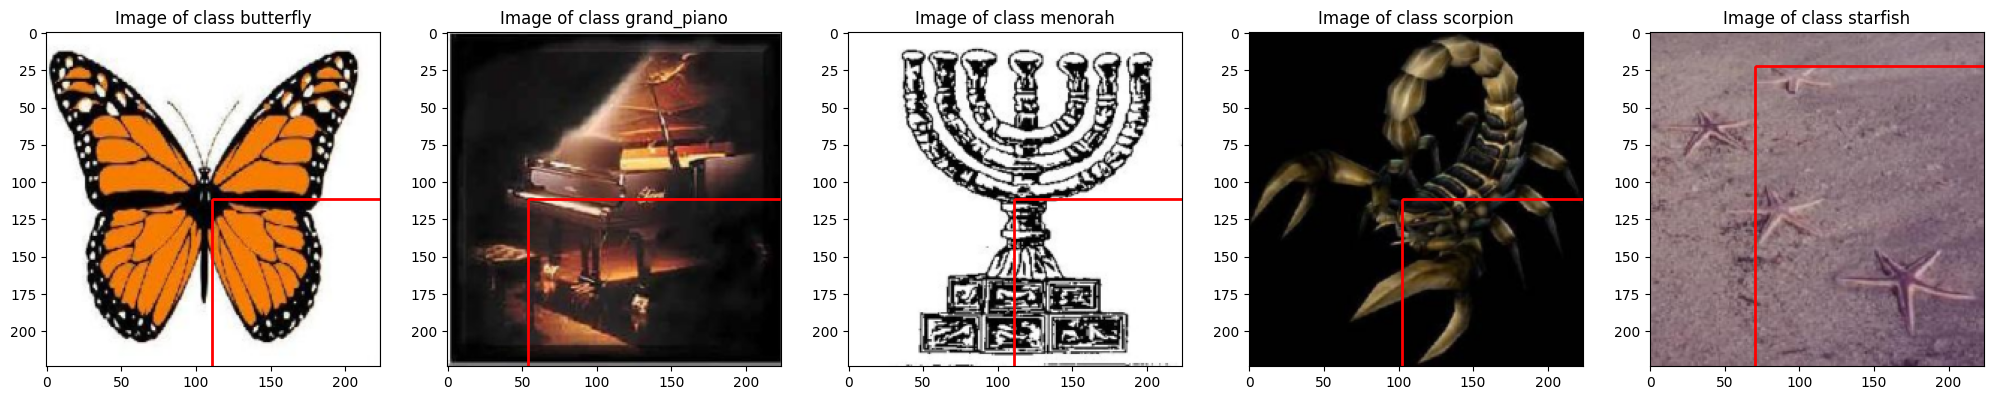

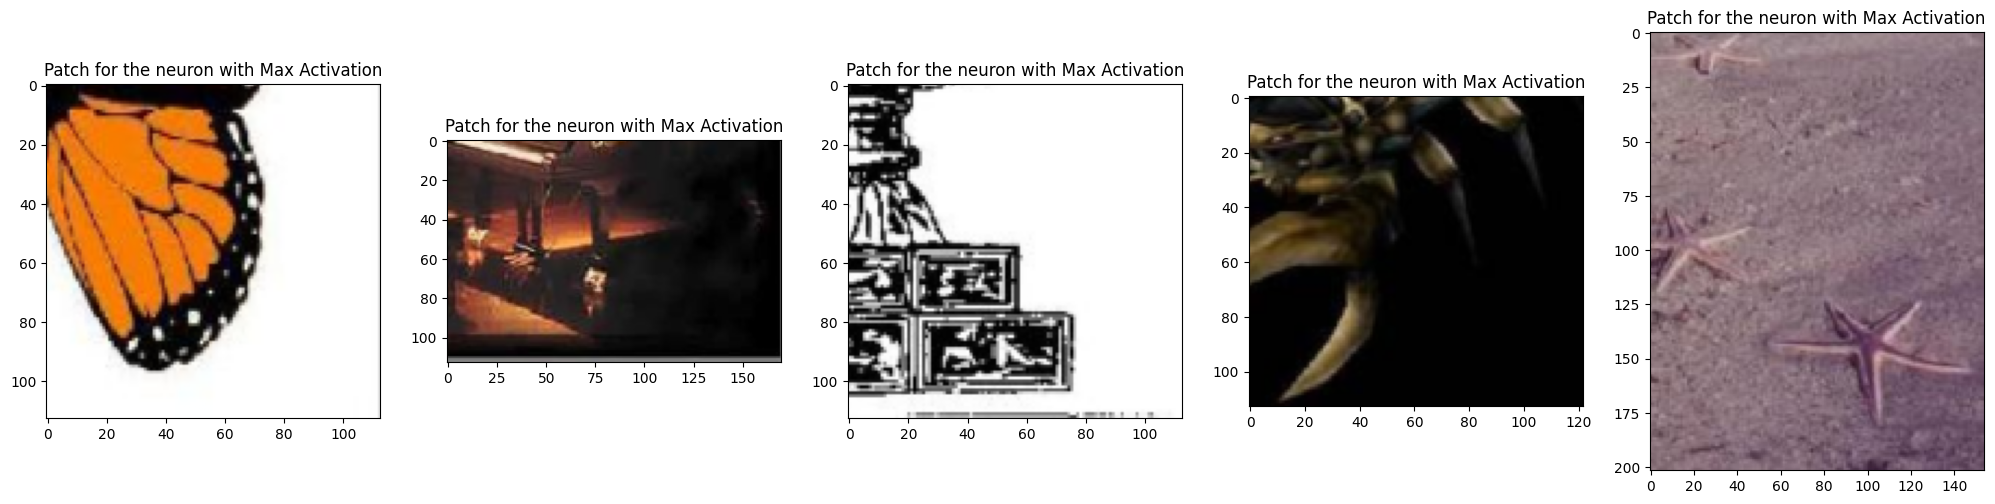

In [38]:
import matplotlib.patches as patches
# Visualize the receptive field on the input image
def visualize_receptive_field(images_per_class):
    print("Image Patches that maximally activate the neuron.\n")

    # Iterate through the images and find the patch corresponding to the maximally activated neuron
    i=0
    fig, axes1 = plt.subplots(1, 5, figsize=(25, 25))
    fig, axes2 = plt.subplots(1, 5, figsize=(25, 25))
    for class_name, image_tensor in images_per_class.items():
        # Display the image with the patch corresponding to the maximally activated neuron
        # image_tensor = torch.clamp(image_tensor, min=0.0, max=1.0)
        axes1[i].imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy(), cmap='cividis')
        axes1[i].set_title(f'Image of class {class_name}')
        # axes1[i].axis('off')
        image_tensor = image_tensor.to(device)
        model.to(device)

        max_activation_index, max_activation_value, conv_output = find_maximally_activated_neuron(model, image_tensor)
        _, layer_info = output_per_layer(model, image_tensor)

        # Compute the receptive field
        receptive_field_x, receptive_field_y, receptive_field_size = compute_receptive_field(layer_info, max_activation_index)
        rect = patches.Rectangle(
            (receptive_field_x - receptive_field_size[1] // 2, receptive_field_y - receptive_field_size[0] // 2),
            receptive_field_size[1],
            receptive_field_size[0],
            edgecolor='red',
            facecolor='none',
            linewidth=2)

        axes1[i].add_patch(rect)

        receptive_field = extract_receptive_field(image_tensor, receptive_field_size, [receptive_field_x, receptive_field_y])
        axes2[i].imshow(receptive_field, cmap='cividis')
        axes2[i].set_title(f'Patch for the neuron with Max Activation')
        # axes2[i].axis('off')
        i = i+1

visualize_receptive_field(images_per_class)